In [74]:
from langchain.schema import HumanMessage, SystemMessage
from langgraph.graph import StateGraph, END, START
from langgraph.checkpoint.memory import MemorySaver
from langchain_openai import ChatOpenAI

In [94]:
from typing import List, Optional, Dict, Union
from pydantic import BaseModel, Field

class StudyTask(BaseModel):
    date: str  # YYYY-MM-DD
    start_time: str  # HH:MM
    end_time: str  # HH:MM
    topic: str

class TentativePhase(BaseModel):
    phase_name: str
    start_date: str
    end_date: str
    topics: List[str]

class TentativePhaseList(BaseModel):
    phases: List[TentativePhase]

class StudyTaskList(BaseModel):
    tasks : List[StudyTask]
    
class StudyPlanState(BaseModel):
    exam_name: str
    exam_date: str
    daily_hours: int
    syllabus: Dict[str, Union[List[str], Dict[str, List[str]]]]
    start_date: str
    paper_pattern: Dict[str, Union[str, int, Dict, List]] = Field(
    description="Official exam pattern including marks distribution, question types, negative marking, etc."
    )
    tentative_plan: Optional[TentativePhaseList] | List[str] = []
    approved_phase: Optional[TentativePhaseList] | List[str] | List[TentativePhase]= []
    detailed_tasks: Optional[StudyTaskList] | List[str] = []


In [95]:
# from langchain.prompts import PromptTemplate

# TENTATIVE_ROADMAP_PROMPT = PromptTemplate(
#     input_variables=["exam_name", "exam_date", "daily_hours", "syllabus", "start_date"],
#     template="""
# You are an expert exam planner. Create a tentative high-level study roadmap.

# Exam: {exam_name}
# Exam Date: {exam_date}
# Daily Study Hours: {daily_hours}
# Syllabus: {syllabus}
# Start Date: {start_date}

# Rules:
# 1. Divide the syllabus into balanced phases from start date until the exam date.
# 2. Each phase should have:
#    - phase_name
#    - start_date
#    - end_date
#    - topics (list)
# 3. Sundays should be used for "Weekly Revision" — mention them in description if relevant.
# 4. Output only valid JSON:
# [
#   {{
#     "phase_name": "...",
#     "start_date": "YYYY-MM-DD",
#     "end_date": "YYYY-MM-DD",
#     "topics": ["topic1", "topic2"]
#   }}
# ]
# """
# )


In [119]:
from langchain.prompts import PromptTemplate

TENTATIVE_ROADMAP_PROMPT = PromptTemplate(
    input_variables=["exam_name", "exam_date", "daily_hours", "syllabus", "start_date", 'paper_pattern'],
    template="""

You are an expert study plan generator.

Exam: {exam_name} (Date: {exam_date})
Start date: {start_date}
Daily study hours: {daily_hours}
Syllabus (hierarchical): {syllabus}
Exam Pattern: {paper_pattern}

Instructions:

1. Split the time into phases with start_date, end_date, and topics (topics may come from any syllabus section or subsection), DO NOT MISS ANY TOPIC.
2. Sundays are reserved for "Weekly Revision".
3. Balance the roadmap according to the exam pattern:
   - Give proportionally more focus to sections that carry higher marks (e.g., Subject Questions, Engineering Mathematics, General Aptitude).
   - Consider the skills tested (Recall, Comprehension, Application, Analysis).
   - Consider the difficulty and time remaining for the preparation.
4. Return only valid JSON as a list of phases, like:
[
  {{
    "name": "Phase 1: Probability and Statistics",
    "start_date": "YYYY-MM-DD",
    "end_date": "YYYY-MM-DD",
    "topics": ["Counting", "Probability axioms", ...]
  }}
]
"""

)

In [134]:
DETAILED_2W_PLAN_PROMPT = PromptTemplate(
    input_variables=["exam_name", "exam_date", "daily_hours", "phase_name", "phase_start", "phase_end", "syllabus_for_phase", "sundays", 'paper_pattern'],
    template="""
You are a smart study plan generator.

Exam: {exam_name} ({exam_date})
Phase: {phase_name} ({phase_start} → {phase_end})
Daily Study Hours: {daily_hours}
Syllabus topics for this phase: {syllabus_for_phase}
Sundays in range: {sundays}
Exam Pattern: {paper_pattern}

Instructure:
1. Generate a **detailed daily schedule for the current phase**.
2. Assign enough time according to the difficulty of each topic:
3. On Sundays, set topic to "Weekly Revision".
4. Add a mock test and analysis event at the end of the phase. 
5. There should always be a buffer of some days if possible ** not necessarily **, in case if the student could not attend some day.
5. Balance time based on marks weightage from the exam pattern.
6. Each non-Sunday must have study tasks totalling {daily_hours} hours.
7. Output only valid JSON:
[
  {{
    "date": "YYYY-MM-DD",
    "start_time": "HH:MM",
    "end_time": "HH:MM",
    "topic": "..."
  }}
]
"""
)


In [121]:
def merge_tentative(state: StudyPlanState, new_phases: TentativePhaseList) -> StudyPlanState:
    state.tentative_plan = new_phases
    idx = len(state.approved_phase)
    state.approved_phase.append(state.tentative_plan.phases[idx])
    return state

def merge_detailed(state: StudyPlanState, new_tasks: StudyTaskList) -> StudyPlanState:
    state.detailed_tasks = new_tasks
    return state


In [122]:
from dotenv import load_dotenv

load_dotenv()

llm = ChatOpenAI(model = 'gpt-4o', temperature = 0)

In [100]:
# Node 1: Tentative plan
def generate_tentative_plan(state: StudyPlanState) -> StudyPlanState:

    tentative_llm = llm.with_structured_output(TentativePhaseList)

    prompt = [
        SystemMessage(content="You are a smart exam roadmap generator."),
        HumanMessage(content=TENTATIVE_ROADMAP_PROMPT.format(
            exam_name=state.exam_name,
            exam_date=state.exam_date,
            daily_hours=state.daily_hours,
            syllabus=state.syllabus,
            start_date=state.start_date,
            paper_pattern = state.paper_pattern
        ))
    ]
    response = tentative_llm.invoke(prompt)
    print(response)
    return merge_tentative(state, response)

In [39]:
initial_state = StudyPlanState(
    exam_name="GATE DA 2026",
    exam_date="2026-02-01",
    daily_hours= 4,
    paper_pattern={
  "Particulars": {
    "Examination Mode": "The test papers will be in English. Computer Based Test (CBT) [will be conducted at select centers in select cities].",
    "Duration": "3 Hours*",
    "Number of Subjects (Papers)": 30,
    "Sections": "General Aptitude (GA) + Candidate's Selected Subjects",
    "Type of Questions": [
      "Candidate’s Selected Subject(s)",
      "Multiple Choice Questions (MCQ)",
      "Multiple Select Questions (MSQ)",
      "Numerical Answer Type (NAT) Questions"
    ],
    "Questions for Testing Abilities": [
      "Recall",
      "Comprehension",
      "Application",
      "Analysis & Synthesis"
    ],
    "Distribution of Marks (except AR, CY, DA, EY, GG, MA, PH, ST, XH, XL)": {
      "General Aptitude": "15 marks",
      "Engineering Mathematics**": "13 marks",
      "Subject Questions": "72 marks",
      "Total": "100 marks",
      "Note": "XE includes Engineering Mathematics section XE-A of 15 marks"
    },
    "Distribution of Marks (AR, CY, DA, EY, GG, MA, PH, ST, XH, XL)": {
      "General Aptitude": "15 marks",
      "Subject Questions": "85 marks",
      "Total": "100 marks"
    },
    "Marking Scheme": "Questions carry 1 mark or 2 marks",
    "Negative Marking": {
      "MCQ": {
        "1-mark question": "-1/3 mark for wrong answer",
        "2-mark question": "-2/3 mark for wrong answer"
      },
      "MSQ": "No negative marking, no partial marking",
      "NAT": "No negative marking"
    }
  }
}
,
    syllabus={
         "AI": [
    "Search: informed, uninformed, adversarial",
    "Logic: propositional, predicate",
    "Reasoning under uncertainty: conditional independence representation, exact inference through variable elimination, approximate inference through sampling"
  ],
  "Probability and Statistics": [
    "Counting (permutation and combinations)",
    "Probability axioms",
    "Sample space",
    "Events",
    "Independent events",
    "Mutually exclusive events",
    "Marginal, conditional and joint probability",
    "Bayes Theorem",
    "Conditional expectation and variance",
    "Mean, median, mode and standard deviation",
    "Correlation and covariance",
    "Random variables",
    "Discrete random variables and probability mass functions",
    "Uniform distribution",
    "Bernoulli distribution",
    "Binomial distribution",
    "Continuous random variables and probability distribution function",
    "Exponential distribution",
    "Poisson distribution",
    "Normal distribution",
    "Standard normal distribution",
    "t-distribution",
    "Chi-squared distributions",
    "Cumulative distribution function",
    "Conditional PDF",
    "Central limit theorem",
    "Confidence interval",
    "z-test",
    "t-test",
    "Chi-squared test"
  ],
  "Linear Algebra": [
    "Vector space",
    "Subspaces",
    "Linear dependence and independence of vectors",
    "Matrices",
    "Projection matrix",
    "Orthogonal matrix",
    "Idempotent matrix",
    "Partition matrix and their properties",
    "Quadratic forms",
    "Systems of linear equations and solutions",
    "Gaussian elimination",
    "Eigenvalues and eigenvectors",
    "Determinant",
    "Rank",
    "Nullity",
    "Projections",
    "LU decomposition",
    "Singular value decomposition"
  ],
  "Calculus and Optimization": [
    "Functions of a single variable",
    "Limit",
    "Continuity and differentiability",
    "Taylor series",
    "Maxima and minima",
    "Optimization involving a single variable"
  ],
  "Programming, Data Structures and Algorithms": {
    "Programming": [
      "Programming in Python"
    ],
    "Data Structures": [
      "Stacks",
      "Queues",
      "Linked lists",
      "Trees",
      "Hash tables"
    ],
    "Search Algorithms": [
      "Linear search",
      "Binary search"
    ],
    "Sorting Algorithms": [
      "Selection sort",
      "Bubble sort",
      "Insertion sort"
    ],
    "Divide and Conquer": [
      "Mergesort",
      "Quicksort"
    ],
    "Graph Theory": [
      "Introduction to graph theory",
      "Basic graph algorithms: traversals and shortest path"
    ]
  },
  "Database Management and Warehousing": [
    "ER-model",
    "Relational model: relational algebra, tuple calculus",
    "SQL",
    "Integrity constraints",
    "Normal form",
    "File organization",
    "Indexing",
    "Data types",
    "Data transformation: normalization, discretization, sampling, compression",
    "Data warehouse modelling: schema for multidimensional data models",
    "Concept hierarchies",
    "Measures: categorization and computations"
  ],
  "Machine Learning": {
    "Supervised Learning": [
      "Regression and classification problems",
      "Simple linear regression",
      "Multiple linear regression",
      "Ridge regression",
      "Logistic regression",
      "K-nearest neighbour",
      "Naive Bayes classifier",
      "Linear discriminant analysis",
      "Support vector machine",
      "Decision trees",
      "Bias-variance trade-off",
      "Cross-validation methods: leave-one-out (LOO) cross-validation, k-folds cross-validation",
      "Multi-layer perceptron",
      "Feed-forward neural network"
    ],
    "Unsupervised Learning": [
      "Clustering algorithms",
      "K-means / K-medoid",
      "Hierarchical clustering",
      "Top-down, bottom-up: single-linkage, multiple-linkage",
      "Dimensionality reduction",
      "Principal component analysis"
    ]
  }
 
}
,
    start_date="2025-09-25"
)

In [40]:
generate_tentative_plan(initial_state)

phases=[TentativePhase(phase_name='Phase 1: Probability and Statistics', start_date='2025-09-25', end_date='2025-10-15', topics=['Counting (permutation and combinations)', 'Probability axioms', 'Sample space', 'Events', 'Independent events', 'Mutually exclusive events', 'Marginal, conditional and joint probability', 'Bayes Theorem', 'Conditional expectation and variance', 'Mean, median, mode and standard deviation', 'Correlation and covariance', 'Random variables', 'Discrete random variables and probability mass functions', 'Uniform distribution', 'Bernoulli distribution', 'Binomial distribution', 'Continuous random variables and probability distribution function', 'Exponential distribution', 'Poisson distribution', 'Normal distribution', 'Standard normal distribution', 't-distribution', 'Chi-squared distributions', 'Cumulative distribution function', 'Conditional PDF', 'Central limit theorem', 'Confidence interval', 'z-test', 't-test', 'Chi-squared test']), TentativePhase(phase_name='

StudyPlanState(exam_name='GATE DA 2026', exam_date='2026-02-01', daily_hours=4, syllabus={'AI': ['Search: informed, uninformed, adversarial', 'Logic: propositional, predicate', 'Reasoning under uncertainty: conditional independence representation, exact inference through variable elimination, approximate inference through sampling'], 'Probability and Statistics': ['Counting (permutation and combinations)', 'Probability axioms', 'Sample space', 'Events', 'Independent events', 'Mutually exclusive events', 'Marginal, conditional and joint probability', 'Bayes Theorem', 'Conditional expectation and variance', 'Mean, median, mode and standard deviation', 'Correlation and covariance', 'Random variables', 'Discrete random variables and probability mass functions', 'Uniform distribution', 'Bernoulli distribution', 'Binomial distribution', 'Continuous random variables and probability distribution function', 'Exponential distribution', 'Poisson distribution', 'Normal distribution', 'Standard nor

In [ ]:
# # Node 2: Human approval
# def wait_for_approval(state: StudyPlanState) -> StudyPlanState:

#     approved = False
#     while True:

#         daily_hours = input('Enter daily time you can give for preparation in (hrs): ')
#         if not daily_hours.isalpha() and 1 <= int(daily_hours) <= 24:
#             break
#         else:
#             print('Input should be between 1 and 24')
    
#     state.daily_hours = daily_hours
#     while not approved:

#         print("\n--- Tentative Plan ---")

#         for idx, phase in enumerate(state.tentative_plan.phases):

   

#             print(f"{idx+1}. {phase.phase_name} ({phase.start_date} → {phase.end_date}) Topics: {phase.topics}")
#         choice = input("Select a to approve (or 'r' to regenerate): ")
#         if choice.lower() == 'r':
#             state = generate_tentative_plan(state)

#         elif choice.lower() == 'a':
#             idx = len(state.approved_phase)
#             state.approved_phase.append(state.tentative_plan.phases[idx])
#             approved = True
#         else:
#             print('Invalid input...')
#     return state

In [101]:
# Node 3: Detailed 2-week plan
from datetime import datetime, timedelta
def generate_detailed_plan(state: StudyPlanState) -> StudyPlanState:
    start = datetime.strptime(state.approved_phase[-1].start_date, "%Y-%m-%d")
    # end = start + timedelta(days=13)
    sundays = [
        (start + timedelta(days=i)).strftime("%Y-%m-%d")
        for i in range(14)
        if (start + timedelta(days=i)).weekday() == 6
    ]

    llm = ChatOpenAI(model = 'gpt-4o', temperature = 0, max_completion_tokens=  5000)
    detailed_llm = llm.with_structured_output(StudyTaskList)

    prompt = [
        SystemMessage(content="You are a detailed study schedule generator."),
        HumanMessage(content=DETAILED_2W_PLAN_PROMPT.format(
            exam_name=state.exam_name,
            exam_date=state.exam_date,
            daily_hours=state.daily_hours,
            phase_name=state.approved_phase[-1].phase_name,
            phase_start=state.approved_phase[-1].start_date,
            phase_end=state.approved_phase[-1].end_date,
            syllabus_for_phase=state.approved_phase[-1].topics,
            sundays=sundays,
            paper_pattern = state.paper_pattern
        ))
    ]

    response = detailed_llm.invoke(prompt)
    print(prompt)
    return merge_detailed(state, response)

In [51]:
initial_state = StudyPlanState(exam_name='GATE DA 2026', exam_date='2026-02-01', daily_hours=4, syllabus={'AI': ['Search: informed, uninformed, adversarial', 'Logic: propositional, predicate', 'Reasoning under uncertainty: conditional independence representation, exact inference through variable elimination, approximate inference through sampling'], 'Probability and Statistics': ['Counting (permutation and combinations)', 'Probability axioms', 'Sample space', 'Events', 'Independent events', 'Mutually exclusive events', 'Marginal, conditional and joint probability', 'Bayes Theorem', 'Conditional expectation and variance', 'Mean, median, mode and standard deviation', 'Correlation and covariance', 'Random variables', 'Discrete random variables and probability mass functions', 'Uniform distribution', 'Bernoulli distribution', 'Binomial distribution', 'Continuous random variables and probability distribution function', 'Exponential distribution', 'Poisson distribution', 'Normal distribution', 'Standard normal distribution', 't-distribution', 'Chi-squared distributions', 'Cumulative distribution function', 'Conditional PDF', 'Central limit theorem', 'Confidence interval', 'z-test', 't-test', 'Chi-squared test'], 'Linear Algebra': ['Vector space', 'Subspaces', 'Linear dependence and independence of vectors', 'Matrices', 'Projection matrix', 'Orthogonal matrix', 'Idempotent matrix', 'Partition matrix and their properties', 'Quadratic forms', 'Systems of linear equations and solutions', 'Gaussian elimination', 'Eigenvalues and eigenvectors', 'Determinant', 'Rank', 'Nullity', 'Projections', 'LU decomposition', 'Singular value decomposition'], 'Calculus and Optimization': ['Functions of a single variable', 'Limit', 'Continuity and differentiability', 'Taylor series', 'Maxima and minima', 'Optimization involving a single variable'], 'Programming, Data Structures and Algorithms': {'Programming': ['Programming in Python'], 'Data Structures': ['Stacks', 'Queues', 'Linked lists', 'Trees', 'Hash tables'], 'Search Algorithms': ['Linear search', 'Binary search'], 'Sorting Algorithms': ['Selection sort', 'Bubble sort', 'Insertion sort'], 'Divide and Conquer': ['Mergesort', 'Quicksort'], 'Graph Theory': ['Introduction to graph theory', 'Basic graph algorithms: traversals and shortest path']}, 'Database Management and Warehousing': ['ER-model', 'Relational model: relational algebra, tuple calculus', 'SQL', 'Integrity constraints', 'Normal form', 'File organization', 'Indexing', 'Data types', 'Data transformation: normalization, discretization, sampling, compression', 'Data warehouse modelling: schema for multidimensional data models', 'Concept hierarchies', 'Measures: categorization and computations'], 'Machine Learning': {'Supervised Learning': ['Regression and classification problems', 'Simple linear regression', 'Multiple linear regression', 'Ridge regression', 'Logistic regression', 'K-nearest neighbour', 'Naive Bayes classifier', 'Linear discriminant analysis', 'Support vector machine', 'Decision trees', 'Bias-variance trade-off', 'Cross-validation methods: leave-one-out (LOO) cross-validation, k-folds cross-validation', 'Multi-layer perceptron', 'Feed-forward neural network'], 'Unsupervised Learning': ['Clustering algorithms', 'K-means / K-medoid', 'Hierarchical clustering', 'Top-down, bottom-up: single-linkage, multiple-linkage', 'Dimensionality reduction', 'Principal component analysis']}}, start_date='2025-09-25', paper_pattern={'Particulars': {'Examination Mode': 'The test papers will be in English. Computer Based Test (CBT) [will be conducted at select centers in select cities].', 'Duration': '3 Hours*', 'Number of Subjects (Papers)': 30, 'Sections': "General Aptitude (GA) + Candidate's Selected Subjects", 'Type of Questions': ['Candidate’s Selected Subject(s)', 'Multiple Choice Questions (MCQ)', 'Multiple Select Questions (MSQ)', 'Numerical Answer Type (NAT) Questions'], 'Questions for Testing Abilities': ['Recall', 'Comprehension', 'Application', 'Analysis & Synthesis'], 'Distribution of Marks (except AR, CY, DA, EY, GG, MA, PH, ST, XH, XL)': {'General Aptitude': '15 marks', 'Engineering Mathematics**': '13 marks', 'Subject Questions': '72 marks', 'Total': '100 marks', 'Note': 'XE includes Engineering Mathematics section XE-A of 15 marks'}, 'Distribution of Marks (AR, CY, DA, EY, GG, MA, PH, ST, XH, XL)': {'General Aptitude': '15 marks', 'Subject Questions': '85 marks', 'Total': '100 marks'}, 'Marking Scheme': 'Questions carry 1 mark or 2 marks', 'Negative Marking': {'MCQ': {'1-mark question': '-1/3 mark for wrong answer', '2-mark question': '-2/3 mark for wrong answer'}, 'MSQ': 'No negative marking, no partial marking', 'NAT': 'No negative marking'}}}, tentative_plan=TentativePhaseList(phases=[TentativePhase(phase_name='Phase 1: Probability and Statistics', start_date='2025-09-25', end_date='2025-10-15', topics=['Counting (permutation and combinations)', 'Probability axioms', 'Sample space', 'Events', 'Independent events', 'Mutually exclusive events', 'Marginal, conditional and joint probability', 'Bayes Theorem', 'Conditional expectation and variance', 'Mean, median, mode and standard deviation', 'Correlation and covariance', 'Random variables', 'Discrete random variables and probability mass functions', 'Uniform distribution', 'Bernoulli distribution', 'Binomial distribution', 'Continuous random variables and probability distribution function', 'Exponential distribution', 'Poisson distribution', 'Normal distribution', 'Standard normal distribution', 't-distribution', 'Chi-squared distributions', 'Cumulative distribution function', 'Conditional PDF', 'Central limit theorem', 'Confidence interval', 'z-test', 't-test', 'Chi-squared test']), TentativePhase(phase_name='Phase 2: Linear Algebra', start_date='2025-10-16', end_date='2025-11-05', topics=['Vector space', 'Subspaces', 'Linear dependence and independence of vectors', 'Matrices', 'Projection matrix', 'Orthogonal matrix', 'Idempotent matrix', 'Partition matrix and their properties', 'Quadratic forms', 'Systems of linear equations and solutions', 'Gaussian elimination', 'Eigenvalues and eigenvectors', 'Determinant', 'Rank', 'Nullity', 'Projections', 'LU decomposition', 'Singular value decomposition']), TentativePhase(phase_name='Phase 3: Calculus and Optimization', start_date='2025-11-06', end_date='2025-11-15', topics=['Functions of a single variable', 'Limit', 'Continuity and differentiability', 'Taylor series', 'Maxima and minima', 'Optimization involving a single variable']), TentativePhase(phase_name='Phase 4: AI and Machine Learning', start_date='2025-11-16', end_date='2025-12-10', topics=['Search: informed, uninformed, adversarial', 'Logic: propositional, predicate', 'Reasoning under uncertainty: conditional independence representation, exact inference through variable elimination, approximate inference through sampling', 'Supervised Learning: Regression and classification problems', 'Simple linear regression', 'Multiple linear regression', 'Ridge regression', 'Logistic regression', 'K-nearest neighbour', 'Naive Bayes classifier', 'Linear discriminant analysis', 'Support vector machine', 'Decision trees', 'Bias-variance trade-off', 'Cross-validation methods: leave-one-out (LOO) cross-validation, k-folds cross-validation', 'Multi-layer perceptron', 'Feed-forward neural network', 'Unsupervised Learning: Clustering algorithms', 'K-means / K-medoid', 'Hierarchical clustering', 'Top-down, bottom-up: single-linkage, multiple-linkage', 'Dimensionality reduction', 'Principal component analysis']), TentativePhase(phase_name='Phase 5: Programming, Data Structures and Algorithms', start_date='2025-12-11', end_date='2026-01-05', topics=['Programming in Python', 'Stacks', 'Queues', 'Linked lists', 'Trees', 'Hash tables', 'Linear search', 'Binary search', 'Selection sort', 'Bubble sort', 'Insertion sort', 'Mergesort', 'Quicksort', 'Introduction to graph theory', 'Basic graph algorithms: traversals and shortest path']), TentativePhase(phase_name='Phase 6: Database Management and Warehousing', start_date='2026-01-06', end_date='2026-01-20', topics=['ER-model', 'Relational model: relational algebra, tuple calculus', 'SQL', 'Integrity constraints', 'Normal form', 'File organization', 'Indexing', 'Data types', 'Data transformation: normalization, discretization, sampling, compression', 'Data warehouse modelling: schema for multidimensional data models', 'Concept hierarchies', 'Measures: categorization and computations']), TentativePhase(phase_name='Phase 7: Final Revision and Mock Tests', start_date='2026-01-21', end_date='2026-01-31', topics=['Comprehensive revision of all topics', 'Mock tests focusing on General Aptitude and Subject Questions'])]), approved_phase=[TentativePhase(phase_name='Phase 1: Probability and Statistics', start_date='2025-09-25', end_date='2025-10-15', topics=['Counting (permutation and combinations)', 'Probability axioms', 'Sample space', 'Events', 'Independent events', 'Mutually exclusive events', 'Marginal, conditional and joint probability', 'Bayes Theorem', 'Conditional expectation and variance', 'Mean, median, mode and standard deviation', 'Correlation and covariance', 'Random variables', 'Discrete random variables and probability mass functions', 'Uniform distribution', 'Bernoulli distribution', 'Binomial distribution', 'Continuous random variables and probability distribution function', 'Exponential distribution', 'Poisson distribution', 'Normal distribution', 'Standard normal distribution', 't-distribution', 'Chi-squared distributions', 'Cumulative distribution function', 'Conditional PDF', 'Central limit theorem', 'Confidence interval', 'z-test', 't-test', 'Chi-squared test'])], detailed_tasks=[])

In [52]:
generate_detailed_plan(initial_state)

[SystemMessage(content='You are a detailed study schedule generator.', additional_kwargs={}, response_metadata={}), HumanMessage(content='\nYou are a smart study plan generator.\n\nExam: GATE DA 2026 (2026-02-01)\nPhase: Phase 1: Probability and Statistics (2025-09-25 → 2025-10-15)\nDaily Study Hours: 4\nSyllabus topics for this phase: [\'Counting (permutation and combinations)\', \'Probability axioms\', \'Sample space\', \'Events\', \'Independent events\', \'Mutually exclusive events\', \'Marginal, conditional and joint probability\', \'Bayes Theorem\', \'Conditional expectation and variance\', \'Mean, median, mode and standard deviation\', \'Correlation and covariance\', \'Random variables\', \'Discrete random variables and probability mass functions\', \'Uniform distribution\', \'Bernoulli distribution\', \'Binomial distribution\', \'Continuous random variables and probability distribution function\', \'Exponential distribution\', \'Poisson distribution\', \'Normal distribution\', \

StudyPlanState(exam_name='GATE DA 2026', exam_date='2026-02-01', daily_hours=4, syllabus={'AI': ['Search: informed, uninformed, adversarial', 'Logic: propositional, predicate', 'Reasoning under uncertainty: conditional independence representation, exact inference through variable elimination, approximate inference through sampling'], 'Probability and Statistics': ['Counting (permutation and combinations)', 'Probability axioms', 'Sample space', 'Events', 'Independent events', 'Mutually exclusive events', 'Marginal, conditional and joint probability', 'Bayes Theorem', 'Conditional expectation and variance', 'Mean, median, mode and standard deviation', 'Correlation and covariance', 'Random variables', 'Discrete random variables and probability mass functions', 'Uniform distribution', 'Bernoulli distribution', 'Binomial distribution', 'Continuous random variables and probability distribution function', 'Exponential distribution', 'Poisson distribution', 'Normal distribution', 'Standard nor

In [ ]:
StudyPlanState(exam_name='GATE DA 2026', exam_date='2026-02-01', daily_hours=4, syllabus={'AI': ['Search: informed, uninformed, adversarial', 'Logic: propositional, predicate', 'Reasoning under uncertainty: conditional independence representation, exact inference through variable elimination, approximate inference through sampling'], 'Probability and Statistics': ['Counting (permutation and combinations)', 'Probability axioms', 'Sample space', 'Events', 'Independent events', 'Mutually exclusive events', 'Marginal, conditional and joint probability', 'Bayes Theorem', 'Conditional expectation and variance', 'Mean, median, mode and standard deviation', 'Correlation and covariance', 'Random variables', 'Discrete random variables and probability mass functions', 'Uniform distribution', 'Bernoulli distribution', 'Binomial distribution', 'Continuous random variables and probability distribution function', 'Exponential distribution', 'Poisson distribution', 'Normal distribution', 'Standard normal distribution', 't-distribution', 'Chi-squared distributions', 'Cumulative distribution function', 'Conditional PDF', 'Central limit theorem', 'Confidence interval', 'z-test', 't-test', 'Chi-squared test'], 'Linear Algebra': ['Vector space', 'Subspaces', 'Linear dependence and independence of vectors', 'Matrices', 'Projection matrix', 'Orthogonal matrix', 'Idempotent matrix', 'Partition matrix and their properties', 'Quadratic forms', 'Systems of linear equations and solutions', 'Gaussian elimination', 'Eigenvalues and eigenvectors', 'Determinant', 'Rank', 'Nullity', 'Projections', 'LU decomposition', 'Singular value decomposition'], 'Calculus and Optimization': ['Functions of a single variable', 'Limit', 'Continuity and differentiability', 'Taylor series', 'Maxima and minima', 'Optimization involving a single variable'], 'Programming, Data Structures and Algorithms': {'Programming': ['Programming in Python'], 'Data Structures': ['Stacks', 'Queues', 'Linked lists', 'Trees', 'Hash tables'], 'Search Algorithms': ['Linear search', 'Binary search'], 'Sorting Algorithms': ['Selection sort', 'Bubble sort', 'Insertion sort'], 'Divide and Conquer': ['Mergesort', 'Quicksort'], 'Graph Theory': ['Introduction to graph theory', 'Basic graph algorithms: traversals and shortest path']}, 'Database Management and Warehousing': ['ER-model', 'Relational model: relational algebra, tuple calculus', 'SQL', 'Integrity constraints', 'Normal form', 'File organization', 'Indexing', 'Data types', 'Data transformation: normalization, discretization, sampling, compression', 'Data warehouse modelling: schema for multidimensional data models', 'Concept hierarchies', 'Measures: categorization and computations'], 'Machine Learning': {'Supervised Learning': ['Regression and classification problems', 'Simple linear regression', 'Multiple linear regression', 'Ridge regression', 'Logistic regression', 'K-nearest neighbour', 'Naive Bayes classifier', 'Linear discriminant analysis', 'Support vector machine', 'Decision trees', 'Bias-variance trade-off', 'Cross-validation methods: leave-one-out (LOO) cross-validation, k-folds cross-validation', 'Multi-layer perceptron', 'Feed-forward neural network'], 'Unsupervised Learning': ['Clustering algorithms', 'K-means / K-medoid', 'Hierarchical clustering', 'Top-down, bottom-up: single-linkage, multiple-linkage', 'Dimensionality reduction', 'Principal component analysis']}}, start_date='2025-09-25', paper_pattern={'Particulars': {'Examination Mode': 'The test papers will be in English. Computer Based Test (CBT) [will be conducted at select centers in select cities].', 'Duration': '3 Hours*', 'Number of Subjects (Papers)': 30, 'Sections': "General Aptitude (GA) + Candidate's Selected Subjects", 'Type of Questions': ['Candidate’s Selected Subject(s)', 'Multiple Choice Questions (MCQ)', 'Multiple Select Questions (MSQ)', 'Numerical Answer Type (NAT) Questions'], 'Questions for Testing Abilities': ['Recall', 'Comprehension', 'Application', 'Analysis & Synthesis'], 'Distribution of Marks (except AR, CY, DA, EY, GG, MA, PH, ST, XH, XL)': {'General Aptitude': '15 marks', 'Engineering Mathematics**': '13 marks', 'Subject Questions': '72 marks', 'Total': '100 marks', 'Note': 'XE includes Engineering Mathematics section XE-A of 15 marks'}, 'Distribution of Marks (AR, CY, DA, EY, GG, MA, PH, ST, XH, XL)': {'General Aptitude': '15 marks', 'Subject Questions': '85 marks', 'Total': '100 marks'}, 'Marking Scheme': 'Questions carry 1 mark or 2 marks', 'Negative Marking': {'MCQ': {'1-mark question': '-1/3 mark for wrong answer', '2-mark question': '-2/3 mark for wrong answer'}, 'MSQ': 'No negative marking, no partial marking', 'NAT': 'No negative marking'}}}, tentative_plan=TentativePhaseList(phases=[TentativePhase(phase_name='Phase 1: Probability and Statistics', start_date='2025-09-25', end_date='2025-10-15', topics=['Counting (permutation and combinations)', 'Probability axioms', 'Sample space', 'Events', 'Independent events', 'Mutually exclusive events', 'Marginal, conditional and joint probability', 'Bayes Theorem', 'Conditional expectation and variance', 'Mean, median, mode and standard deviation', 'Correlation and covariance', 'Random variables', 'Discrete random variables and probability mass functions', 'Uniform distribution', 'Bernoulli distribution', 'Binomial distribution', 'Continuous random variables and probability distribution function', 'Exponential distribution', 'Poisson distribution', 'Normal distribution', 'Standard normal distribution', 't-distribution', 'Chi-squared distributions', 'Cumulative distribution function', 'Conditional PDF', 'Central limit theorem', 'Confidence interval', 'z-test', 't-test', 'Chi-squared test']), TentativePhase(phase_name='Phase 2: Linear Algebra', start_date='2025-10-16', end_date='2025-11-05', topics=['Vector space', 'Subspaces', 'Linear dependence and independence of vectors', 'Matrices', 'Projection matrix', 'Orthogonal matrix', 'Idempotent matrix', 'Partition matrix and their properties', 'Quadratic forms', 'Systems of linear equations and solutions', 'Gaussian elimination', 'Eigenvalues and eigenvectors', 'Determinant', 'Rank', 'Nullity', 'Projections', 'LU decomposition', 'Singular value decomposition']), TentativePhase(phase_name='Phase 3: Calculus and Optimization', start_date='2025-11-06', end_date='2025-11-15', topics=['Functions of a single variable', 'Limit', 'Continuity and differentiability', 'Taylor series', 'Maxima and minima', 'Optimization involving a single variable']), TentativePhase(phase_name='Phase 4: AI and Machine Learning', start_date='2025-11-16', end_date='2025-12-10', topics=['Search: informed, uninformed, adversarial', 'Logic: propositional, predicate', 'Reasoning under uncertainty: conditional independence representation, exact inference through variable elimination, approximate inference through sampling', 'Supervised Learning: Regression and classification problems', 'Simple linear regression', 'Multiple linear regression', 'Ridge regression', 'Logistic regression', 'K-nearest neighbour', 'Naive Bayes classifier', 'Linear discriminant analysis', 'Support vector machine', 'Decision trees', 'Bias-variance trade-off', 'Cross-validation methods: leave-one-out (LOO) cross-validation, k-folds cross-validation', 'Multi-layer perceptron', 'Feed-forward neural network', 'Unsupervised Learning: Clustering algorithms', 'K-means / K-medoid', 'Hierarchical clustering', 'Top-down, bottom-up: single-linkage, multiple-linkage', 'Dimensionality reduction', 'Principal component analysis']), TentativePhase(phase_name='Phase 5: Programming, Data Structures and Algorithms', start_date='2025-12-11', end_date='2026-01-05', topics=['Programming in Python', 'Stacks', 'Queues', 'Linked lists', 'Trees', 'Hash tables', 'Linear search', 'Binary search', 'Selection sort', 'Bubble sort', 'Insertion sort', 'Mergesort', 'Quicksort', 'Introduction to graph theory', 'Basic graph algorithms: traversals and shortest path']), TentativePhase(phase_name='Phase 6: Database Management and Warehousing', start_date='2026-01-06', end_date='2026-01-20', topics=['ER-model', 'Relational model: relational algebra, tuple calculus', 'SQL', 'Integrity constraints', 'Normal form', 'File organization', 'Indexing', 'Data types', 'Data transformation: normalization, discretization, sampling, compression', 'Data warehouse modelling: schema for multidimensional data models', 'Concept hierarchies', 'Measures: categorization and computations']), TentativePhase(phase_name='Phase 7: Final Revision and Mock Tests', start_date='2026-01-21', end_date='2026-01-31', topics=['Comprehensive revision of all topics', 'Mock tests focusing on General Aptitude and Subject Questions'])]), approved_phase=[TentativePhase(phase_name='Phase 1: Probability and Statistics', start_date='2025-09-25', end_date='2025-10-15', topics=['Counting (permutation and combinations)', 'Probability axioms', 'Sample space', 'Events', 'Independent events', 'Mutually exclusive events', 'Marginal, conditional and joint probability', 'Bayes Theorem', 'Conditional expectation and variance', 'Mean, median, mode and standard deviation', 'Correlation and covariance', 'Random variables', 'Discrete random variables and probability mass functions', 'Uniform distribution', 'Bernoulli distribution', 'Binomial distribution', 'Continuous random variables and probability distribution function', 'Exponential distribution', 'Poisson distribution', 'Normal distribution', 'Standard normal distribution', 't-distribution', 'Chi-squared distributions', 'Cumulative distribution function', 'Conditional PDF', 'Central limit theorem', 'Confidence interval', 'z-test', 't-test', 'Chi-squared test'])], detailed_tasks=StudyTaskList(tasks=[StudyTask(date='2025-09-25', start_time='09:00', end_time='11:00', topic='Counting (permutation and combinations)'), StudyTask(date='2025-09-25', start_time='11:15', end_time='13:15', topic='Probability axioms, Sample space, Events'), StudyTask(date='2025-09-26', start_time='09:00', end_time='11:00', topic='Independent events, Mutually exclusive events'), StudyTask(date='2025-09-26', start_time='11:15', end_time='13:15', topic='Marginal, conditional and joint probability'), StudyTask(date='2025-09-27', start_time='09:00', end_time='11:00', topic='Bayes Theorem, Conditional expectation and variance'), StudyTask(date='2025-09-27', start_time='11:15', end_time='13:15', topic='Mean, median, mode and standard deviation'), StudyTask(date='2025-09-28', start_time='09:00', end_time='11:00', topic='Weekly Revision'), StudyTask(date='2025-09-28', start_time='11:15', end_time='13:15', topic='Weekly Revision'), StudyTask(date='2025-09-29', start_time='09:00', end_time='11:00', topic='Correlation and covariance, Random variables'), StudyTask(date='2025-09-29', start_time='11:15', end_time='13:15', topic='Discrete random variables and probability mass functions'), StudyTask(date='2025-09-30', start_time='09:00', end_time='11:00', topic='Uniform distribution, Bernoulli distribution'), StudyTask(date='2025-09-30', start_time='11:15', end_time='13:15', topic='Binomial distribution, Continuous random variables and probability distribution function'), StudyTask(date='2025-10-01', start_time='09:00', end_time='11:00', topic='Exponential distribution, Poisson distribution'), StudyTask(date='2025-10-01', start_time='11:15', end_time='13:15', topic='Normal distribution, Standard normal distribution'), StudyTask(date='2025-10-02', start_time='09:00', end_time='11:00', topic='t-distribution, Chi-squared distributions'), StudyTask(date='2025-10-02', start_time='11:15', end_time='13:15', topic='Cumulative distribution function, Conditional PDF'), StudyTask(date='2025-10-03', start_time='09:00', end_time='11:00', topic='Central limit theorem, Confidence interval'), StudyTask(date='2025-10-03', start_time='11:15', end_time='13:15', topic='z-test, t-test'), StudyTask(date='2025-10-04', start_time='09:00', end_time='11:00', topic='Chi-squared test, Review of distributions'), StudyTask(date='2025-10-04', start_time='11:15', end_time='13:15', topic='Practice problems on probability and statistics'), StudyTask(date='2025-10-05', start_time='09:00', end_time='11:00', topic='Weekly Revision'), StudyTask(date='2025-10-05', start_time='11:15', end_time='13:15', topic='Weekly Revision'), StudyTask(date='2025-10-06', start_time='09:00', end_time='11:00', topic='Advanced problems on probability'), StudyTask(date='2025-10-06', start_time='11:15', end_time='13:15', topic='Advanced problems on statistics'), StudyTask(date='2025-10-07', start_time='09:00', end_time='11:00', topic='Mock test and analysis'), StudyTask(date='2025-10-07', start_time='11:15', end_time='13:15', topic='Mock test and analysis')]))

In [ ]:
detailed_tasks=StudyTaskList(tasks=[StudyTask(date='2025-09-25', start_time='09:00', end_time='11:00', topic='Counting (permutation and combinations)'), StudyTask(date='2025-09-25', start_time='11:15', end_time='13:15', topic='Probability axioms, Sample space, Events'), StudyTask(date='2025-09-26', start_time='09:00', end_time='11:00', topic='Independent events, Mutually exclusive events'), StudyTask(date='2025-09-26', start_time='11:15', end_time='13:15', topic='Marginal, conditional and joint probability'), StudyTask(date='2025-09-27', start_time='09:00', end_time='11:00', topic='Bayes Theorem, Conditional expectation and variance'), StudyTask(date='2025-09-27', start_time='11:15', end_time='13:15', topic='Mean, median, mode and standard deviation'), StudyTask(date='2025-09-28', start_time='09:00', end_time='11:00', topic='Weekly Revision'), StudyTask(date='2025-09-28', start_time='11:15', end_time='13:15', topic='Weekly Revision'), StudyTask(date='2025-09-29', start_time='09:00', end_time='11:00', topic='Correlation and covariance, Random variables'), StudyTask(date='2025-09-29', start_time='11:15', end_time='13:15', topic='Discrete random variables and probability mass functions'), StudyTask(date='2025-09-30', start_time='09:00', end_time='11:00', topic='Uniform distribution, Bernoulli distribution'), StudyTask(date='2025-09-30', start_time='11:15', end_time='13:15', topic='Binomial distribution, Continuous random variables and probability distribution function'), StudyTask(date='2025-10-01', start_time='09:00', end_time='11:00', topic='Exponential distribution, Poisson distribution'), StudyTask(date='2025-10-01', start_time='11:15', end_time='13:15', topic='Normal distribution, Standard normal distribution'), StudyTask(date='2025-10-02', start_time='09:00', end_time='11:00', topic='t-distribution, Chi-squared distributions'), StudyTask(date='2025-10-02', start_time='11:15', end_time='13:15', topic='Cumulative distribution function, Conditional PDF'), StudyTask(date='2025-10-03', start_time='09:00', end_time='11:00', topic='Central limit theorem, Confidence interval'), StudyTask(date='2025-10-03', start_time='11:15', end_time='13:15', topic='z-test, t-test'), StudyTask(date='2025-10-04', start_time='09:00', end_time='11:00', topic='Chi-squared test, Review of distributions'), StudyTask(date='2025-10-04', start_time='11:15', end_time='13:15', topic='Practice problems on probability and statistics'), StudyTask(date='2025-10-05', start_time='09:00', end_time='11:00', topic='Weekly Revision'), StudyTask(date='2025-10-05', start_time='11:15', end_time='13:15', topic='Weekly Revision'), StudyTask(date='2025-10-06', start_time='09:00', end_time='11:00', topic='Advanced problems on probability'), StudyTask(date='2025-10-06', start_time='11:15', end_time='13:15', topic='Advanced problems on statistics'), StudyTask(date='2025-10-07', start_time='09:00', end_time='11:00', topic='Mock test and analysis'), StudyTask(date='2025-10-07', start_time='11:15', end_time='13:15', topic='Mock test and analysis')])

In [102]:
# Node 4: Push to Google Calendar

def push_to_calendar(state: StudyPlanState) -> StudyPlanState:
    for task in state.detailed_tasks.tasks:
        print(f"[Calendar Event] {task.date} {task.start_time}-{task.end_time}: {task.topic}")
    return state

In [54]:
push_to_calendar(StudyPlanState(exam_name='GATE DA 2026', exam_date='2026-02-01', daily_hours=4, syllabus={'AI': ['Search: informed, uninformed, adversarial', 'Logic: propositional, predicate', 'Reasoning under uncertainty: conditional independence representation, exact inference through variable elimination, approximate inference through sampling'], 'Probability and Statistics': ['Counting (permutation and combinations)', 'Probability axioms', 'Sample space', 'Events', 'Independent events', 'Mutually exclusive events', 'Marginal, conditional and joint probability', 'Bayes Theorem', 'Conditional expectation and variance', 'Mean, median, mode and standard deviation', 'Correlation and covariance', 'Random variables', 'Discrete random variables and probability mass functions', 'Uniform distribution', 'Bernoulli distribution', 'Binomial distribution', 'Continuous random variables and probability distribution function', 'Exponential distribution', 'Poisson distribution', 'Normal distribution', 'Standard normal distribution', 't-distribution', 'Chi-squared distributions', 'Cumulative distribution function', 'Conditional PDF', 'Central limit theorem', 'Confidence interval', 'z-test', 't-test', 'Chi-squared test'], 'Linear Algebra': ['Vector space', 'Subspaces', 'Linear dependence and independence of vectors', 'Matrices', 'Projection matrix', 'Orthogonal matrix', 'Idempotent matrix', 'Partition matrix and their properties', 'Quadratic forms', 'Systems of linear equations and solutions', 'Gaussian elimination', 'Eigenvalues and eigenvectors', 'Determinant', 'Rank', 'Nullity', 'Projections', 'LU decomposition', 'Singular value decomposition'], 'Calculus and Optimization': ['Functions of a single variable', 'Limit', 'Continuity and differentiability', 'Taylor series', 'Maxima and minima', 'Optimization involving a single variable'], 'Programming, Data Structures and Algorithms': {'Programming': ['Programming in Python'], 'Data Structures': ['Stacks', 'Queues', 'Linked lists', 'Trees', 'Hash tables'], 'Search Algorithms': ['Linear search', 'Binary search'], 'Sorting Algorithms': ['Selection sort', 'Bubble sort', 'Insertion sort'], 'Divide and Conquer': ['Mergesort', 'Quicksort'], 'Graph Theory': ['Introduction to graph theory', 'Basic graph algorithms: traversals and shortest path']}, 'Database Management and Warehousing': ['ER-model', 'Relational model: relational algebra, tuple calculus', 'SQL', 'Integrity constraints', 'Normal form', 'File organization', 'Indexing', 'Data types', 'Data transformation: normalization, discretization, sampling, compression', 'Data warehouse modelling: schema for multidimensional data models', 'Concept hierarchies', 'Measures: categorization and computations'], 'Machine Learning': {'Supervised Learning': ['Regression and classification problems', 'Simple linear regression', 'Multiple linear regression', 'Ridge regression', 'Logistic regression', 'K-nearest neighbour', 'Naive Bayes classifier', 'Linear discriminant analysis', 'Support vector machine', 'Decision trees', 'Bias-variance trade-off', 'Cross-validation methods: leave-one-out (LOO) cross-validation, k-folds cross-validation', 'Multi-layer perceptron', 'Feed-forward neural network'], 'Unsupervised Learning': ['Clustering algorithms', 'K-means / K-medoid', 'Hierarchical clustering', 'Top-down, bottom-up: single-linkage, multiple-linkage', 'Dimensionality reduction', 'Principal component analysis']}}, start_date='2025-09-25', paper_pattern={'Particulars': {'Examination Mode': 'The test papers will be in English. Computer Based Test (CBT) [will be conducted at select centers in select cities].', 'Duration': '3 Hours*', 'Number of Subjects (Papers)': 30, 'Sections': "General Aptitude (GA) + Candidate's Selected Subjects", 'Type of Questions': ['Candidate’s Selected Subject(s)', 'Multiple Choice Questions (MCQ)', 'Multiple Select Questions (MSQ)', 'Numerical Answer Type (NAT) Questions'], 'Questions for Testing Abilities': ['Recall', 'Comprehension', 'Application', 'Analysis & Synthesis'], 'Distribution of Marks (except AR, CY, DA, EY, GG, MA, PH, ST, XH, XL)': {'General Aptitude': '15 marks', 'Engineering Mathematics**': '13 marks', 'Subject Questions': '72 marks', 'Total': '100 marks', 'Note': 'XE includes Engineering Mathematics section XE-A of 15 marks'}, 'Distribution of Marks (AR, CY, DA, EY, GG, MA, PH, ST, XH, XL)': {'General Aptitude': '15 marks', 'Subject Questions': '85 marks', 'Total': '100 marks'}, 'Marking Scheme': 'Questions carry 1 mark or 2 marks', 'Negative Marking': {'MCQ': {'1-mark question': '-1/3 mark for wrong answer', '2-mark question': '-2/3 mark for wrong answer'}, 'MSQ': 'No negative marking, no partial marking', 'NAT': 'No negative marking'}}}, tentative_plan=TentativePhaseList(phases=[TentativePhase(phase_name='Phase 1: Probability and Statistics', start_date='2025-09-25', end_date='2025-10-15', topics=['Counting (permutation and combinations)', 'Probability axioms', 'Sample space', 'Events', 'Independent events', 'Mutually exclusive events', 'Marginal, conditional and joint probability', 'Bayes Theorem', 'Conditional expectation and variance', 'Mean, median, mode and standard deviation', 'Correlation and covariance', 'Random variables', 'Discrete random variables and probability mass functions', 'Uniform distribution', 'Bernoulli distribution', 'Binomial distribution', 'Continuous random variables and probability distribution function', 'Exponential distribution', 'Poisson distribution', 'Normal distribution', 'Standard normal distribution', 't-distribution', 'Chi-squared distributions', 'Cumulative distribution function', 'Conditional PDF', 'Central limit theorem', 'Confidence interval', 'z-test', 't-test', 'Chi-squared test']), TentativePhase(phase_name='Phase 2: Linear Algebra', start_date='2025-10-16', end_date='2025-11-05', topics=['Vector space', 'Subspaces', 'Linear dependence and independence of vectors', 'Matrices', 'Projection matrix', 'Orthogonal matrix', 'Idempotent matrix', 'Partition matrix and their properties', 'Quadratic forms', 'Systems of linear equations and solutions', 'Gaussian elimination', 'Eigenvalues and eigenvectors', 'Determinant', 'Rank', 'Nullity', 'Projections', 'LU decomposition', 'Singular value decomposition']), TentativePhase(phase_name='Phase 3: Calculus and Optimization', start_date='2025-11-06', end_date='2025-11-15', topics=['Functions of a single variable', 'Limit', 'Continuity and differentiability', 'Taylor series', 'Maxima and minima', 'Optimization involving a single variable']), TentativePhase(phase_name='Phase 4: AI and Machine Learning', start_date='2025-11-16', end_date='2025-12-10', topics=['Search: informed, uninformed, adversarial', 'Logic: propositional, predicate', 'Reasoning under uncertainty: conditional independence representation, exact inference through variable elimination, approximate inference through sampling', 'Supervised Learning: Regression and classification problems', 'Simple linear regression', 'Multiple linear regression', 'Ridge regression', 'Logistic regression', 'K-nearest neighbour', 'Naive Bayes classifier', 'Linear discriminant analysis', 'Support vector machine', 'Decision trees', 'Bias-variance trade-off', 'Cross-validation methods: leave-one-out (LOO) cross-validation, k-folds cross-validation', 'Multi-layer perceptron', 'Feed-forward neural network', 'Unsupervised Learning: Clustering algorithms', 'K-means / K-medoid', 'Hierarchical clustering', 'Top-down, bottom-up: single-linkage, multiple-linkage', 'Dimensionality reduction', 'Principal component analysis']), TentativePhase(phase_name='Phase 5: Programming, Data Structures and Algorithms', start_date='2025-12-11', end_date='2026-01-05', topics=['Programming in Python', 'Stacks', 'Queues', 'Linked lists', 'Trees', 'Hash tables', 'Linear search', 'Binary search', 'Selection sort', 'Bubble sort', 'Insertion sort', 'Mergesort', 'Quicksort', 'Introduction to graph theory', 'Basic graph algorithms: traversals and shortest path']), TentativePhase(phase_name='Phase 6: Database Management and Warehousing', start_date='2026-01-06', end_date='2026-01-20', topics=['ER-model', 'Relational model: relational algebra, tuple calculus', 'SQL', 'Integrity constraints', 'Normal form', 'File organization', 'Indexing', 'Data types', 'Data transformation: normalization, discretization, sampling, compression', 'Data warehouse modelling: schema for multidimensional data models', 'Concept hierarchies', 'Measures: categorization and computations']), TentativePhase(phase_name='Phase 7: Final Revision and Mock Tests', start_date='2026-01-21', end_date='2026-01-31', topics=['Comprehensive revision of all topics', 'Mock tests focusing on General Aptitude and Subject Questions'])]), approved_phase=[TentativePhase(phase_name='Phase 1: Probability and Statistics', start_date='2025-09-25', end_date='2025-10-15', topics=['Counting (permutation and combinations)', 'Probability axioms', 'Sample space', 'Events', 'Independent events', 'Mutually exclusive events', 'Marginal, conditional and joint probability', 'Bayes Theorem', 'Conditional expectation and variance', 'Mean, median, mode and standard deviation', 'Correlation and covariance', 'Random variables', 'Discrete random variables and probability mass functions', 'Uniform distribution', 'Bernoulli distribution', 'Binomial distribution', 'Continuous random variables and probability distribution function', 'Exponential distribution', 'Poisson distribution', 'Normal distribution', 'Standard normal distribution', 't-distribution', 'Chi-squared distributions', 'Cumulative distribution function', 'Conditional PDF', 'Central limit theorem', 'Confidence interval', 'z-test', 't-test', 'Chi-squared test'])], detailed_tasks=StudyTaskList(tasks=[StudyTask(date='2025-09-25', start_time='09:00', end_time='11:00', topic='Counting (permutation and combinations)'), StudyTask(date='2025-09-25', start_time='11:15', end_time='13:15', topic='Probability axioms, Sample space, Events'), StudyTask(date='2025-09-26', start_time='09:00', end_time='11:00', topic='Independent events, Mutually exclusive events'), StudyTask(date='2025-09-26', start_time='11:15', end_time='13:15', topic='Marginal, conditional and joint probability'), StudyTask(date='2025-09-27', start_time='09:00', end_time='11:00', topic='Bayes Theorem, Conditional expectation and variance'), StudyTask(date='2025-09-27', start_time='11:15', end_time='13:15', topic='Mean, median, mode and standard deviation'), StudyTask(date='2025-09-28', start_time='09:00', end_time='11:00', topic='Weekly Revision'), StudyTask(date='2025-09-28', start_time='11:15', end_time='13:15', topic='Weekly Revision'), StudyTask(date='2025-09-29', start_time='09:00', end_time='11:00', topic='Correlation and covariance, Random variables'), StudyTask(date='2025-09-29', start_time='11:15', end_time='13:15', topic='Discrete random variables and probability mass functions'), StudyTask(date='2025-09-30', start_time='09:00', end_time='11:00', topic='Uniform distribution, Bernoulli distribution'), StudyTask(date='2025-09-30', start_time='11:15', end_time='13:15', topic='Binomial distribution, Continuous random variables and probability distribution function'), StudyTask(date='2025-10-01', start_time='09:00', end_time='11:00', topic='Exponential distribution, Poisson distribution'), StudyTask(date='2025-10-01', start_time='11:15', end_time='13:15', topic='Normal distribution, Standard normal distribution'), StudyTask(date='2025-10-02', start_time='09:00', end_time='11:00', topic='t-distribution, Chi-squared distributions'), StudyTask(date='2025-10-02', start_time='11:15', end_time='13:15', topic='Cumulative distribution function, Conditional PDF'), StudyTask(date='2025-10-03', start_time='09:00', end_time='11:00', topic='Central limit theorem, Confidence interval'), StudyTask(date='2025-10-03', start_time='11:15', end_time='13:15', topic='z-test, t-test'), StudyTask(date='2025-10-04', start_time='09:00', end_time='11:00', topic='Chi-squared test, Review of distributions'), StudyTask(date='2025-10-04', start_time='11:15', end_time='13:15', topic='Practice problems on probability and statistics'), StudyTask(date='2025-10-05', start_time='09:00', end_time='11:00', topic='Weekly Revision'), StudyTask(date='2025-10-05', start_time='11:15', end_time='13:15', topic='Weekly Revision'), StudyTask(date='2025-10-06', start_time='09:00', end_time='11:00', topic='Advanced problems on probability'), StudyTask(date='2025-10-06', start_time='11:15', end_time='13:15', topic='Advanced problems on statistics'), StudyTask(date='2025-10-07', start_time='09:00', end_time='11:00', topic='Mock test and analysis'), StudyTask(date='2025-10-07', start_time='11:15', end_time='13:15', topic='Mock test and analysis')])))

[Calendar Event] 2025-09-25 09:00-11:00: Counting (permutation and combinations)
[Calendar Event] 2025-09-25 11:15-13:15: Probability axioms, Sample space, Events
[Calendar Event] 2025-09-26 09:00-11:00: Independent events, Mutually exclusive events
[Calendar Event] 2025-09-26 11:15-13:15: Marginal, conditional and joint probability
[Calendar Event] 2025-09-27 09:00-11:00: Bayes Theorem, Conditional expectation and variance
[Calendar Event] 2025-09-27 11:15-13:15: Mean, median, mode and standard deviation
[Calendar Event] 2025-09-28 09:00-11:00: Weekly Revision
[Calendar Event] 2025-09-28 11:15-13:15: Weekly Revision
[Calendar Event] 2025-09-29 09:00-11:00: Correlation and covariance, Random variables
[Calendar Event] 2025-09-29 11:15-13:15: Discrete random variables and probability mass functions
[Calendar Event] 2025-09-30 09:00-11:00: Uniform distribution, Bernoulli distribution
[Calendar Event] 2025-09-30 11:15-13:15: Binomial distribution, Continuous random variables and probabili

StudyPlanState(exam_name='GATE DA 2026', exam_date='2026-02-01', daily_hours=4, syllabus={'AI': ['Search: informed, uninformed, adversarial', 'Logic: propositional, predicate', 'Reasoning under uncertainty: conditional independence representation, exact inference through variable elimination, approximate inference through sampling'], 'Probability and Statistics': ['Counting (permutation and combinations)', 'Probability axioms', 'Sample space', 'Events', 'Independent events', 'Mutually exclusive events', 'Marginal, conditional and joint probability', 'Bayes Theorem', 'Conditional expectation and variance', 'Mean, median, mode and standard deviation', 'Correlation and covariance', 'Random variables', 'Discrete random variables and probability mass functions', 'Uniform distribution', 'Bernoulli distribution', 'Binomial distribution', 'Continuous random variables and probability distribution function', 'Exponential distribution', 'Poisson distribution', 'Normal distribution', 'Standard nor

In [103]:
# Build workflow

workflow = StateGraph(StudyPlanState)


workflow.add_node("generate_tentative_plan", generate_tentative_plan)
workflow.add_node("generate_detailed_plan", generate_detailed_plan)
workflow.add_node("push_to_calendar", push_to_calendar)

workflow.add_edge(START,"generate_tentative_plan")
workflow.add_edge("generate_tentative_plan", "generate_detailed_plan")
workflow.add_edge("generate_detailed_plan", "push_to_calendar")
workflow.add_edge('push_to_calendar', END)


app = workflow.compile()

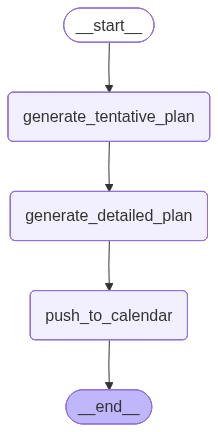

In [104]:
app

In [85]:
with open('sample_syllabus.json', 'r') as f:
    syllabus = f.read()

with open('sample_paper_pattern.json', 'r') as f:
    paper_pattern = f.read()

In [135]:
syllabus = {"Probability and Statistics":["Counting (permutation and combinations)","Probability axioms","Sample space","Events","Independent events","Mutually exclusive events","Marginal, conditional and joint probability","Bayes Theorem","Conditional expectation and variance","Mean, median, mode and standard deviation","Correlation and covariance","Random variables","Discrete random variables and probability mass functions","Uniform distribution","Bernoulli distribution","Binomial distribution","Continuous random variables and probability distribution function","Exponential distribution","Poisson distribution","Normal distribution","Standard normal distribution","t-distribution","Chi-squared distributions","Cumulative distribution function","Conditional PDF","Central limit theorem","Confidence interval","z-test","t-test","Chi-squared test"],"Linear Algebra":["Vector space","Subspaces","Linear dependence and independence of vectors","Matrices","Projection matrix","Orthogonal matrix","Idempotent matrix","Partition matrix and their properties","Quadratic forms","Systems of linear equations and solutions","Gaussian elimination","Eigenvalues and eigenvectors","Determinant","Rank","Nullity","Projections","LU decomposition","Singular value decomposition"],"Calculus and Optimization":["Functions of a single variable","Limit","Continuity and differentiability","Taylor series","Maxima and minima","Optimization involving a single variable"],"Programming, Data Structures and Algorithms":{"Programming":["Programming in Python"],"Data Structures":["Stacks","Queues","Linked lists","Trees","Hash tables"],"Search Algorithms":["Linear search","Binary search"],"Sorting Algorithms":["Selection sort","Bubble sort","Insertion sort"],"Divide and Conquer":["Mergesort","Quicksort"],"Graph Theory":["Introduction to graph theory","Basic graph algorithms: traversals and shortest path"]},"Database Management and Warehousing":["ER-model","Relational model: relational algebra, tuple calculus","SQL","Integrity constraints","Normal form","File organization","Indexing","Data types","Data transformation: normalization, discretization, sampling, compression","Data warehouse modelling: schema for multidimensional data models","Concept hierarchies","Measures: categorization and computations"],"Machine Learning":{"Supervised Learning":["Regression and classification problems","Simple linear regression","Multiple linear regression","Ridge regression","Logistic regression","K-nearest neighbour","Naive Bayes classifier","Linear discriminant analysis","Support vector machine","Decision trees","Bias-variance trade-off","Cross-validation methods: leave-one-out (LOO) cross-validation, k-folds cross-validation","Multi-layer perceptron","Feed-forward neural network"],"Unsupervised Learning":["Clustering algorithms","K-means / K-medoid","Hierarchical clustering","Top-down, bottom-up: single-linkage, multiple-linkage","Dimensionality reduction","Principal component analysis"]},"AI":["Search: informed, uninformed, adversarial","Logic: propositional, predicate","Reasoning under uncertainty: conditional independence representation, exact inference through variable elimination, approximate inference through sampling"]}

In [136]:
paper_pattern = {"Particulars":{"Examination Mode":"The test papers will be in English. Computer Based Test (CBT) [will be conducted at select centers in select cities].","Duration":"3 Hours*","Number of Subjects (Papers)":30,"Sections":"General Aptitude (GA) + Candidate's Selected Subjects","Type of Questions":["Candidate’s Selected Subject(s)","Multiple Choice Questions (MCQ)","Multiple Select Questions (MSQ)","Numerical Answer Type (NAT) Questions"],"Questions for Testing Abilities":["Recall","Comprehension","Application","Analysis & Synthesis"],"Distribution of Marks (except AR, CY, DA, EY, GG, MA, PH, ST, XH, XL)":{"General Aptitude":"15 marks","Engineering Mathematics**":"13 marks","Subject Questions":"72 marks","Total":"100 marks","Note":"XE includes Engineering Mathematics section XE-A of 15 marks"},"Distribution of Marks (AR, CY, DA, EY, GG, MA, PH, ST, XH, XL)":{"General Aptitude":"15 marks","Subject Questions":"85 marks","Total":"100 marks"},"Marking Scheme":"Questions carry 1 mark or 2 marks","Negative Marking":{"MCQ":{"1-mark question":"-1/3 mark for wrong answer","2-mark question":"-2/3 mark for wrong answer"},"MSQ":"No negative marking, no partial marking","NAT":"No negative marking"}}}


In [140]:
initial_state = StudyPlanState(
    exam_name="GATE DA 2026",
    exam_date="2026-02-07",
    syllabus= syllabus,
    paper_pattern= paper_pattern,
    start_date="2025-09-25",
    daily_hours= 4
)

In [141]:
output = app.invoke(initial_state)

phases=[TentativePhase(phase_name='Phase 1: Probability and Statistics', start_date='2025-09-25', end_date='2025-10-15', topics=['Counting (permutation and combinations)', 'Probability axioms', 'Sample space', 'Events', 'Independent events', 'Mutually exclusive events', 'Marginal, conditional and joint probability', 'Bayes Theorem', 'Conditional expectation and variance', 'Mean, median, mode and standard deviation', 'Correlation and covariance', 'Random variables', 'Discrete random variables and probability mass functions', 'Uniform distribution', 'Bernoulli distribution', 'Binomial distribution', 'Continuous random variables and probability distribution function', 'Exponential distribution', 'Poisson distribution', 'Normal distribution', 'Standard normal distribution', 't-distribution', 'Chi-squared distributions', 'Cumulative distribution function', 'Conditional PDF', 'Central limit theorem', 'Confidence interval', 'z-test', 't-test', 'Chi-squared test']), TentativePhase(phase_name='

In [138]:
output = app.invoke(initial_state)

phases=[TentativePhase(phase_name='Phase 1: Probability and Statistics', start_date='2025-09-25', end_date='2025-10-15', topics=['Counting (permutation and combinations)', 'Probability axioms', 'Sample space', 'Events', 'Independent events', 'Mutually exclusive events', 'Marginal, conditional and joint probability', 'Bayes Theorem', 'Conditional expectation and variance', 'Mean, median, mode and standard deviation', 'Correlation and covariance', 'Random variables', 'Discrete random variables and probability mass functions', 'Uniform distribution', 'Bernoulli distribution', 'Binomial distribution', 'Continuous random variables and probability distribution function', 'Exponential distribution', 'Poisson distribution', 'Normal distribution', 'Standard normal distribution', 't-distribution', 'Chi-squared distributions', 'Cumulative distribution function', 'Conditional PDF', 'Central limit theorem', 'Confidence interval', 'z-test', 't-test', 'Chi-squared test']), TentativePhase(phase_name='

In [133]:
output = app.invoke(initial_state)

phases=[TentativePhase(phase_name='Phase 1: Probability and Statistics', start_date='2025-09-25', end_date='2025-10-15', topics=['Counting (permutation and combinations)', 'Probability axioms', 'Sample space', 'Events', 'Independent events', 'Mutually exclusive events', 'Marginal, conditional and joint probability', 'Bayes Theorem', 'Conditional expectation and variance', 'Mean, median, mode and standard deviation', 'Correlation and covariance', 'Random variables', 'Discrete random variables and probability mass functions', 'Uniform distribution', 'Bernoulli distribution', 'Binomial distribution', 'Continuous random variables and probability distribution function', 'Exponential distribution', 'Poisson distribution', 'Normal distribution', 'Standard normal distribution', 't-distribution', 'Chi-squared distributions', 'Cumulative distribution function', 'Conditional PDF', 'Central limit theorem', 'Confidence interval', 'z-test', 't-test', 'Chi-squared test']), TentativePhase(phase_name='

In [124]:
output = app.invoke(initial_state)

phases=[TentativePhase(phase_name='Phase 1: Probability and Statistics', start_date='2025-09-25', end_date='2025-10-15', topics=['Counting (permutation and combinations)', 'Probability axioms', 'Sample space', 'Events', 'Independent events', 'Mutually exclusive events', 'Marginal, conditional and joint probability', 'Bayes Theorem', 'Conditional expectation and variance', 'Mean, median, mode and standard deviation', 'Correlation and covariance', 'Random variables', 'Discrete random variables and probability mass functions', 'Uniform distribution', 'Bernoulli distribution', 'Binomial distribution', 'Continuous random variables and probability distribution function', 'Exponential distribution', 'Poisson distribution', 'Normal distribution', 'Standard normal distribution', 't-distribution', 'Chi-squared distributions', 'Cumulative distribution function', 'Conditional PDF', 'Central limit theorem', 'Confidence interval', 'z-test', 't-test', 'Chi-squared test']), TentativePhase(phase_name='

In [116]:
output = app.invoke(initial_state)

phases=[TentativePhase(phase_name='Phase 1: Probability and Statistics', start_date='2025-09-25', end_date='2025-10-15', topics=['Counting (permutation and combinations)', 'Probability axioms', 'Sample space', 'Events', 'Independent events', 'Mutually exclusive events', 'Marginal, conditional and joint probability', 'Bayes Theorem', 'Conditional expectation and variance', 'Mean, median, mode and standard deviation', 'Correlation and covariance', 'Random variables', 'Discrete random variables and probability mass functions', 'Uniform distribution', 'Bernoulli distribution', 'Binomial distribution', 'Continuous random variables and probability distribution function', 'Exponential distribution', 'Poisson distribution', 'Normal distribution', 'Standard normal distribution', 't-distribution', 'Chi-squared distributions', 'Cumulative distribution function', 'Conditional PDF', 'Central limit theorem', 'Confidence interval', 'z-test', 't-test', 'Chi-squared test']), TentativePhase(phase_name='

In [126]:
output

{'exam_name': 'GATE DA 2026',
 'exam_date': '2026-02-07',
 'daily_hours': 8,
 'syllabus': {'Probability and Statistics': ['Counting (permutation and combinations)',
   'Probability axioms',
   'Sample space',
   'Events',
   'Independent events',
   'Mutually exclusive events',
   'Marginal, conditional and joint probability',
   'Bayes Theorem',
   'Conditional expectation and variance',
   'Mean, median, mode and standard deviation',
   'Correlation and covariance',
   'Random variables',
   'Discrete random variables and probability mass functions',
   'Uniform distribution',
   'Bernoulli distribution',
   'Binomial distribution',
   'Continuous random variables and probability distribution function',
   'Exponential distribution',
   'Poisson distribution',
   'Normal distribution',
   'Standard normal distribution',
   't-distribution',
   'Chi-squared distributions',
   'Cumulative distribution function',
   'Conditional PDF',
   'Central limit theorem',
   'Confidence interval'

In [ ]:
#  google_calendar = 

# StudyTaskList(tasks=[StudyTask(date='2025-09-25', start_time='09:00', end_time='11:00', topic='Counting (permutation and combinations)'), StudyTask(date='2025-09-25', start_time='11:15', end_time='13:15', topic='Probability axioms, Sample space, Events'), StudyTask(date='2025-09-25', start_time='14:00', end_time='16:00', topic='Independent events, Mutually exclusive events'), StudyTask(date='2025-09-25', start_time='16:15', end_time='18:15', topic='Marginal, conditional and joint probability'), StudyTask(date='2025-09-26', start_time='09:00', end_time='11:00', topic='Bayes Theorem'), StudyTask(date='2025-09-26', start_time='11:15', end_time='13:15', topic='Conditional expectation and variance'), StudyTask(date='2025-09-26', start_time='14:00', end_time='16:00', topic='Mean, median, mode and standard deviation'), StudyTask(date='2025-09-26', start_time='16:15', end_time='18:15', topic='Correlation and covariance'), StudyTask(date='2025-09-27', start_time='09:00', end_time='11:00', topic='Random variables'), StudyTask(date='2025-09-27', start_time='11:15', end_time='13:15', topic='Discrete random variables and probability mass functions'), StudyTask(date='2025-09-27', start_time='14:00', end_time='16:00', topic='Uniform distribution, Bernoulli distribution'), StudyTask(date='2025-09-27', start_time='16:15', end_time='18:15', topic='Binomial distribution'), StudyTask(date='2025-09-28', start_time='09:00', end_time='11:00', topic='Weekly Revision'), StudyTask(date='2025-09-28', start_time='11:15', end_time='13:15', topic='Weekly Revision'), StudyTask(date='2025-09-28', start_time='14:00', end_time='16:00', topic='Weekly Revision'), StudyTask(date='2025-09-28', start_time='16:15', end_time='18:15', topic='Weekly Revision'), StudyTask(date='2025-09-29', start_time='09:00', end_time='11:00', topic='Continuous random variables and probability distribution function'), StudyTask(date='2025-09-29', start_time='11:15', end_time='13:15', topic='Exponential distribution'), StudyTask(date='2025-09-29', start_time='14:00', end_time='16:00', topic='Poisson distribution'), StudyTask(date='2025-09-29', start_time='16:15', end_time='18:15', topic='Normal distribution, Standard normal distribution'), StudyTask(date='2025-09-30', start_time='09:00', end_time='11:00', topic='t-distribution'), StudyTask(date='2025-09-30', start_time='11:15', end_time='13:15', topic='Chi-squared distributions'), StudyTask(date='2025-09-30', start_time='14:00', end_time='16:00', topic='Cumulative distribution function'), StudyTask(date='2025-09-30', start_time='16:15', end_time='18:15', topic='Conditional PDF'), StudyTask(date='2025-10-01', start_time='09:00', end_time='11:00', topic='Central limit theorem'), StudyTask(date='2025-10-01', start_time='11:15', end_time='13:15', topic='Confidence interval'), StudyTask(date='2025-10-01', start_time='14:00', end_time='16:00', topic='z-test'), StudyTask(date='2025-10-01', start_time='16:15', end_time='18:15', topic='t-test'), StudyTask(date='2025-10-02', start_time='09:00', end_time='11:00', topic='Chi-squared test'), StudyTask(date='2025-10-02', start_time='11:15', end_time='13:15', topic='Mock Test'), StudyTask(date='2025-10-02', start_time='14:00', end_time='16:00', topic='Mock Test Analysis'), StudyTask(date='2025-10-02', start_time='16:15', end_time='18:15', topic='Mock Test Analysis'), StudyTask(date='2025-10-03', start_time='09:00', end_time='11:00', topic='Counting (permutation and combinations) - Advanced Problems'), StudyTask(date='2025-10-03', start_time='11:15', end_time='13:15', topic='Probability axioms, Sample space, Events - Advanced Problems'), StudyTask(date='2025-10-03', start_time='14:00', end_time='16:00', topic='Independent events, Mutually exclusive events - Advanced Problems'), StudyTask(date='2025-10-03', start_time='16:15', end_time='18:15', topic='Marginal, conditional and joint probability - Advanced Problems'), StudyTask(date='2025-10-04', start_time='09:00', end_time='11:00', topic='Bayes Theorem - Advanced Problems'), StudyTask(date='2025-10-04', start_time='11:15', end_time='13:15', topic='Conditional expectation and variance - Advanced Problems'), StudyTask(date='2025-10-04', start_time='14:00', end_time='16:00', topic='Mean, median, mode and standard deviation - Advanced Problems'), StudyTask(date='2025-10-04', start_time='16:15', end_time='18:15', topic='Correlation and covariance - Advanced Problems'), StudyTask(date='2025-10-05', start_time='09:00', end_time='11:00', topic='Weekly Revision'), StudyTask(date='2025-10-05', start_time='11:15', end_time='13:15', topic='Weekly Revision'), StudyTask(date='2025-10-05', start_time='14:00', end_time='16:00', topic='Weekly Revision'), StudyTask(date='2025-10-05', start_time='16:15', end_time='18:15', topic='Weekly Revision')])